# Predicting order cancellations using getML


In this tutorial, we demonstrate how getML can be applied in an e-commerce context. Using a dataset of about 400,000 orders, our goal is to predict whether an order will be cancelled.

We also show that we can significantly improve our results by using getML's built-in hyperparameter tuning routines.

Summary:

- Prediction type: __Classification model__
- Domain: __E-commerce__
- Prediction target: __Whether an order will be cancelled__ 
- Population size: __397925__

_Author: Dr. Patrick Urbanke_

# Background

The data set contains about 400,000 orders from a British online retailer. Each order consists of a product that has been ordered and a corresponding quantity. Several orders can be summarized onto a single invoice. The goal is to predict whether an order will be cancelled.

Because the company mainly sells to other businesses, the cancellation rate is relatively low, namely 1.83%.

The data set has been originally collected for this study:

> Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).

It has been downloaded from the UCI Machine Learning Repository:

> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

getml.engine.set_project('online_retail')


Connected to project 'online_retail'


Tuning is effective at improving our results, but it takes quite long, so we want to make it optional:

In [2]:
ALLOW_TUNING = False

## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [3]:
fname = "online_retail.csv"

if not os.path.exists(fname):
    fname, res = request.urlretrieve(
        "https://static.getml.com/datasets/online_retail/" + fname, 
        fname
    )
    
full_data_pandas = pd.read_csv(fname, sep="|")

### 1.2 Data preparation

The invoice dates are in a somewhat unusual format, fo we need to rectify that.

In [4]:
def add_zero(string):
    if len(string) == 1:
        return "0" + string
    return string

In [5]:
def format_date(string):
    datetime = string.split(" ")
    assert len(datetime) == 2, "Expected date and time"
    
    date_components = datetime[0].split("/")
    assert len(date_components) == 3, "Expected three date components"
    
    date_components = [add_zero(x) for x in date_components]
    
    return "-".join(date_components) + " " + datetime[1] 

In [6]:
full_data_pandas["InvoiceDate"] = [
    format_date(string) for string in np.asarray(full_data_pandas["InvoiceDate"])
]

In [7]:
full_data_pandas

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50,4.95,12680.0,France


In this data set, the targets aren't as clearly defined as we would like to, so we have do define them ourselves.

In [8]:
def add_target(df):
    df = df.sort_values(by=["Customer ID", "InvoiceDate"])
    
    cancelled = np.zeros(df.shape[0])

    invoice = np.asarray(df["Invoice"])
    stock_code = np.asarray(df["StockCode"])
    customer_id = np.asarray(df["Customer ID"])

    for i in range(len(invoice)):
        if (invoice[i][0] == 'C') or (i == len(invoice) - 1):
            continue

        j = i + 1

        while customer_id[j] == customer_id[i]:
            if (invoice[j][0] == 'C') and (stock_code[i] == stock_code[j]):
                cancelled[i] = 1.0
                break

            if stock_code[i] == stock_code[j]:
                break

            j += 1
    
    df["cancelled"] = cancelled
    
    return df

Also, we want to remove any orders in the data set that are actually cancellations.

In [9]:
def remove_cancellations(df):
    invoice = np.asarray(df["Invoice"])

    is_order = [inv[0] != 'C' for inv in invoice]
    
    df = df[is_order]
    
    return df

In [10]:
full_data_pandas = add_target(full_data_pandas)
full_data_pandas = remove_cancellations(full_data_pandas)

Finally, there are some order for which we do not have a customer ID. We want to remove those.

In [11]:
full_data_pandas = full_data_pandas[~np.isnan(full_data_pandas["Customer ID"])]

Now we can upload the data to getML.

In [12]:
full_data = getml.data.DataFrame.from_pandas(full_data_pandas, "full_data")

full_data

Name,Quantity,Price,Customer ID,cancelled,Invoice,StockCode,Description,InvoiceDate,Country
Role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string
0,74215,1.04,12346,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,2011-01-18 10:01,United Kingdom
1,12,2.1,12347,0,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,2010-12-07 14:57,Iceland
2,4,4.25,12347,0,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,2010-12-07 14:57,Iceland
3,12,3.25,12347,0,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,2010-12-07 14:57,Iceland
4,36,0.65,12347,0,537626,22492,MINI PAINT SET VINTAGE,2010-12-07 14:57,Iceland
,...,...,...,...,...,...,...,...,...
397920,12,0.42,18287,0,570715,22419,LIPSTICK PEN RED,2011-10-12 10:23,United Kingdom
397921,12,2.1,18287,0,570715,22866,HAND WARMER SCOTTY DOG DESIGN,2011-10-12 10:23,United Kingdom
397922,36,1.25,18287,0,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,2011-10-28 09:29,United Kingdom


### 1.3 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [13]:
full_data.set_role("InvoiceDate", getml.data.roles.time_stamp, time_formats=['%Y-%m-%d %H:%M'])
full_data.set_role(["Customer ID", "Invoice"], getml.data.roles.join_key)
full_data.set_role(["cancelled"], getml.data.roles.target)
full_data.set_role(["Quantity", "Price"], getml.data.roles.numerical)
full_data.set_role("Country", getml.data.roles.categorical)
full_data.set_role("Description", getml.data.roles.text)

The *StockCode* is a 5-digit code that uniquely defines a product. It is hierarchical, meaning that every digit has a meaning. We want to make use of that, so we assign a unit to the stock code, which we can reference in our preprocessors.

In [14]:
full_data.set_unit("StockCode", "code")

In [15]:
random = full_data.random()

is_training = (random < 0.7)
is_validation = (~is_training & (random < 0.85))
is_test = (~is_training & ~is_validation)

data_train = full_data.where("data_train", is_training)
data_validation = full_data.where("data_validation", is_validation)
data_test = full_data.where("data_test", is_test)

In [16]:
full_data.set_role("Description", getml.data.roles.unused_string)

## 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In our case, there are two joins we are interested in: 

1) We want to take a look at all of the other orders on the same invoice.

2) We want to check out how often a certain customer has cancelled orders in the past. Here, we limit ourselves to the last 90 days. To avoid data leaks, we set a horizon of one day.

In [17]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

population.join(
    peripheral,
    join_key='Invoice',
    allow_lagged_targets=False
)

population.join(
    peripheral,
    join_key='Customer ID',
    time_stamp='InvoiceDate',
    horizon=getml.data.time.days(1),
    memory=getml.data.time.days(90),
    allow_lagged_targets=True
)

population

placeholder   other placeholder   allow lagged targets   horizon   join keys used   memory      other join keys used   other time stamps used   relationship   time stamps used   upper time stamps used
  0   population    peripheral          False                  0.0       Invoice          0.0         Invoice                                         many-to-many                                            
  1   population    peripheral          True                   86400.0   Customer ID      7776000.0   Customer ID            InvoiceDate              many-to-many   InvoiceDate

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We have mentioned that the *StockCode* is a hierarchical code. To make use of that fact, we use getML's substring preprocessor, extracting the first digit, the first two digits etc. Since we have assigned the unit *code* to the *StockCode*, the preprocessors know which column they should be applied to.

In [18]:
substr1 = getml.preprocessors.Substring(0, 1, "code")
substr2 = getml.preprocessors.Substring(0, 2, "code")
substr3 = getml.preprocessors.Substring(0, 3, "code")

text_field_splitter = getml.preprocessors.TextFieldSplitter()

mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastPropModel(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
    sampling_factor=0.1,
)

feature_selector = getml.predictors.XGBoostClassifier()

predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [19]:
pipe = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    population=population,
    preprocessors=[substr1, substr2, substr3, text_field_splitter, mapping],
    feature_learners=[fast_prop],
    feature_selectors=[feature_selector],
    predictors=[predictor],
    share_selected_features=0.2,
)

pipe

Pipeline(preprocessors=['Substring', 'Substring', 'Substring', 'TextFieldSplitter', 'Mapping'],
         feature_learners=['FastPropModel'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         peripheral=['peripheral'],
         population='population',
         predictors=['XGBoostClassifier'],
         tags=['fast_prop'],
         share_selected_features=0.2)

### 2.3 Model training

In [20]:
pipe.check(data_train, [full_data])

Checking data model...
OK.


In [21]:
pipe.fit(data_train, [full_data])

Checking data model...
OK.

Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

FastProp: Trying 1520 features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:9m:25.958278



Pipeline(preprocessors=['Substring', 'Substring', 'Substring', 'TextFieldSplitter', 'Mapping'],
         feature_learners=['FastPropModel'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         peripheral=['peripheral'],
         population='population',
         predictors=['XGBoostClassifier'],
         tags=['fast_prop'],
         share_selected_features=0.2)

url: http://localhost:1709/#/getpipeline/online_retail/Q8bIiF/0/

### 2.4 Model evaluation

In [22]:
pipe.score(data_test, [full_data])


Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-05-18 20:14:55,data_train,cancelled,0.9825,0.8455,0.07358
1,2021-05-18 20:15:02,data_test,cancelled,0.9825,0.8142,0.0751


### 2.5 Hyperparameter tuning

As we have seen, we can achieve and out-of-sample AUC of over 80%. That is not too bad, but can we do better?

Turns out we can. All we have to do is to use getML's built-in hyperparameter tuning routines. No cheating: We optimize on the validation set, which is different from the testing set.

In [23]:
if ALLOW_TUNING:
    tuned_pipe = getml.hyperopt.tune_predictors(
        pipeline=pipe,
        population_table_training=data_train,
        population_table_validation=data_validation,
        peripheral_tables=[full_data]
    )
else: # If ALLOW_TUNING is false, use the tuned hyperparameters  
    tuned_pipe = copy.deepcopy(pipe)
    tuned_pipe.predictors[0].n_estimators = 996
    tuned_pipe.predictors[0].learning_rate = 0.3
    tuned_pipe.fit(data_train, [full_data])

Checking data model...
OK.

Preprocessing...
[========================================] 100%

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:6m:25.918499



Finally, we evaluate the tuned pipeline on the testing set:

In [24]:
tuned_pipe.score(data_test, [full_data])


Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-05-18 20:21:31,data_train,cancelled,0.9881,0.9723,0.04236
1,2021-05-18 20:21:41,data_test,cancelled,0.9836,0.878,0.06489


As we can see, tuning the hyperparameters can improve the out-of-sample AUC by over 6 percentage points.

### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variable.

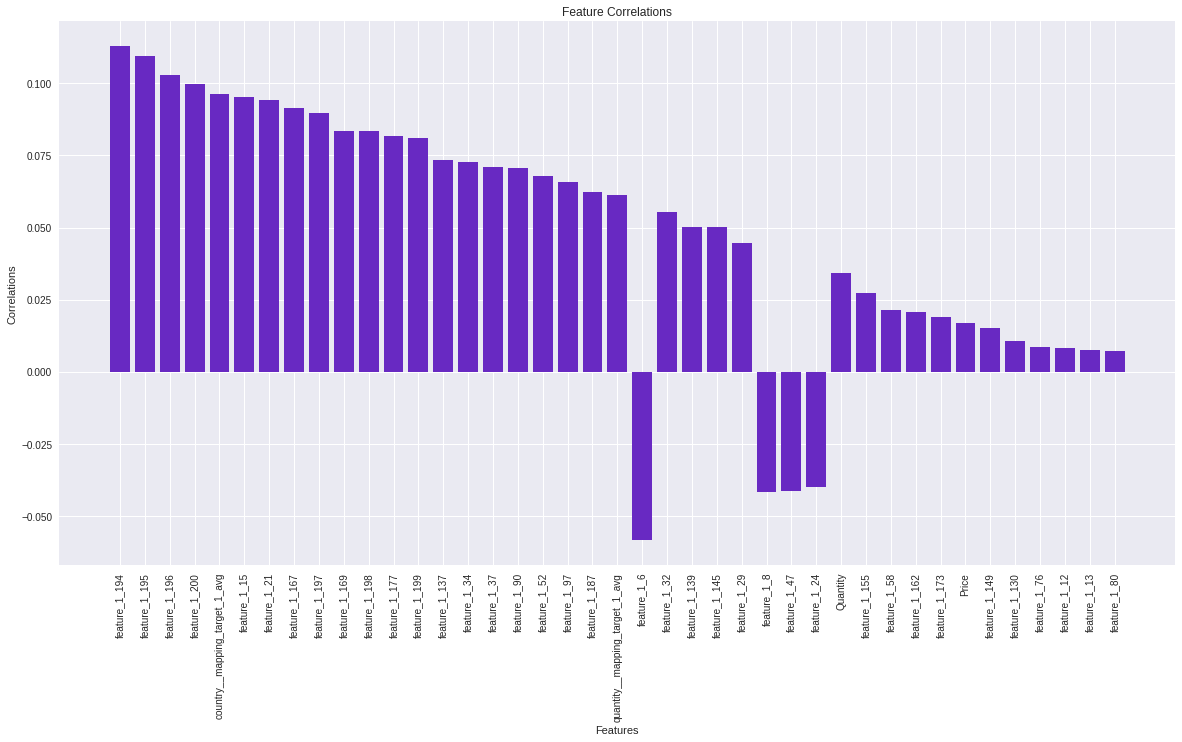

In [25]:
names, correlations = tuned_pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

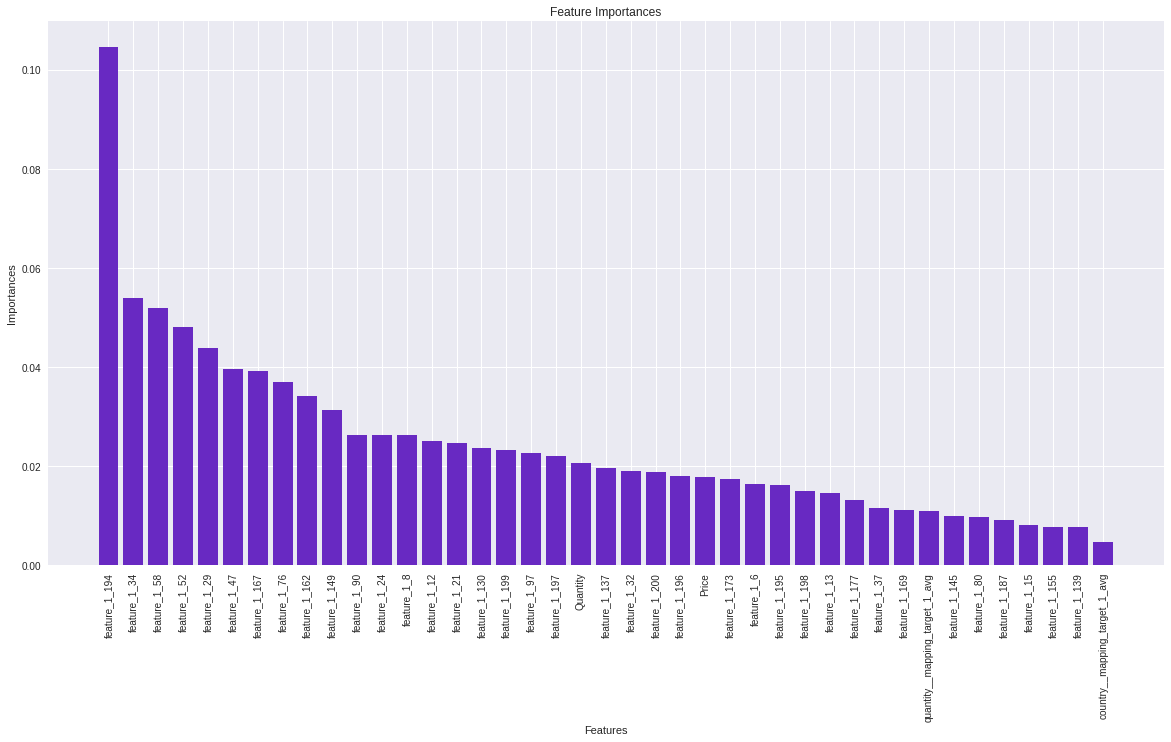

In [26]:
names, importances = tuned_pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

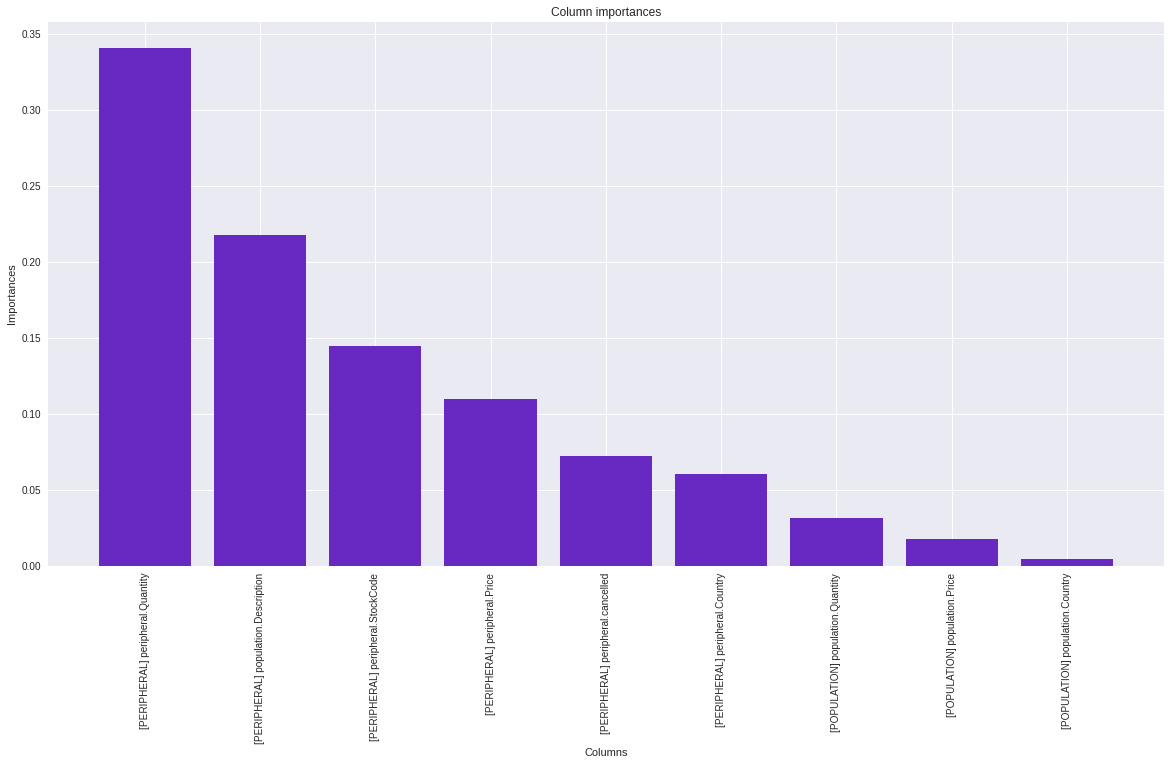

In [27]:
names, importances = tuned_pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Column importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

We can also export the entire pipeline as SQLite3 code. This can be useful for productionization. Please also note the `sqlite3` module in the getML Python API. This creates a folder called "online_retail" which contains the generated pipeline as SQLite3 code.

In [28]:
tuned_pipe.features.to_sql().save("online_retail", split=True)

## 3. Conclusion

In this notebook we have demonstrated how getML can be applied to an e-commerce setting. In particular, we have seen how results can be improved using the built-in hyperparamater tuning routines.

# Next Steps

This tutorial presented an application of getML in the e-commerce context. 

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples. 

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.